
# Preliminary exploration of machine learning models to predict VTEC from GPS position using 30 days of Rouge Auger station (ID 185) running in free GPS mode.

## Combines data from nearby UNAVCO double frequency GNSS station measuring ionospheric VTEC (_Vertical Total Electron Content_)

## The goal is to predict features of VTEC as measured at UNAVCO station using ONLY positioning information from Rouge.

## Different combinations of days o data for training and testing are shown below

## Summary of findings:

- Performance seems better when training with data acquired in the previous contiguous days from the test data.
- Using more than 10 days for building models does not seems too advantegous.

In [1]:
import pandas as pd
import numpy as np
import re
import gpstk
%run -i augergps.py
%matplotlib inline
#output_notebook(resources=bokeh.resources.INLINE)


## 1. Load and parse raw monitoring data

coordinate conversions at [gr-air-modes](https://github.com/bistromath/gr-air-modes/blob/master/python/mlat.py)

In [3]:
d = load_augergps_raw("../../../proyectos/auger/gps/data/source/rouge-2016-04-30days")
mintime = np.min(d.gpstime)
maxtime = np.max(d.gpstime)
print "data from", gpssecs_to_utc(mintime)
print "       to", gpssecs_to_utc(maxtime)

d.to_csv("../../../proyectos/auger/gps/data/station.0185-2016-04_30days.dat", columns=["stationid", "northing", "easting", "height", "gpstime"], index=False)

data from 2016-04-06 19:38:31
       to 2016-05-08 23:59:04


In [4]:
campaigns = {
    "2016.rouge": ["station.0185-2016-04_30days.dat"]
}

In [5]:
stations, campaign_data = load_campaigns(campaigns, datadir="../../../proyectos/auger/gps/data/")

2016.rouge 2016-04-06 19:38:31 -> 2016-05-08 23:59:04


## 2. Enhance positioning data by adding columns:
- smoothing to height, easting and northing by substituting each position by the mean of the previous 10 measurements.
- `secinorbit`: seconds in the orbit period of GPS satellites (23h 56mins)
- `secinorbit`: seconds in the natural 24h day
- `gpsday`: GPS day (GPS day 1 was 1/jan/1980)

In [6]:
c = campaign_data["2016.rouge"]

c = add_second_in_orbit(c, orbit_period = 60*60*24-240)
c = add_gpsday(c)
c = add_second_in_day(c)
c = smooth_col(c, "easting", window_size=100, crop=False)
c = smooth_col(c, "height", window_size=100, crop=False)
c = smooth_col(c, "northing", window_size=100, crop=False)


In [9]:
c.head()

,stationid,northing,easting,height,gpstime,secinorbit,b_secinorbit,gpsday,secinday,b_secinday,s_easting,s_height,s_northing
0,185,609054847,47088083,139183,1144006727,60407,60360,13240,70727,70680,47088083,139183,609054847
1,185,609054847,47088083,139183,1144006734,60414,60360,13240,70734,70680,47088083,139183,609054847
2,185,609054658,47087934,139196,1144006819,60499,60480,13240,70819,70800,47087934,139196,609054658
3,185,609054631,47087917,139347,1144006879,60559,60540,13240,70879,70860,47087917,139347,609054631
4,185,609054643,47087879,139424,1144006939,60619,60600,13240,70939,70920,47087879,139424,609054643


## 3. Process RINEX files from nearby [ELA2](http://www.unavco.org/data/gps-gnss/data-access-methods/dai2/app/dai2.html#4Char=ELA2;scope=Station;sampleRate=normal;4CharMod=startsWith) UNAVCO station

- observation files (`.16o`) contain the distances to visible satellites as measured by the ELA2 station. Distances are referred to as **pseudoranges** measured by timing the signal travel time from each satellite.
- navigation files (`.16n`) contain information on satellite orbits to compute their positions.
- observations are each 30 seconds.
- additional data is computed for each observation from the information on the files:
    - the satellite elevation and azimuth as seen from ELA2
    - the IPP: ionospheric pierce point (lat+lon) of each satellite trajectory assuming the ionosphere as a thin layer at 350km altitude (this is standard in GNSS).
    - the ionospheric disturbance (delay) suffered by each satellite measurement.
    - the total vertical electron content (VTEC) at each IPP (projects iono delay on satellite trajectory upon a vertical line at the IPP)
 
VTEC was computed from SLANT TEC according to [here](http://digitalcommons.usu.edu/cgi/viewcontent.cgi?article=1418&context=etd)


In [12]:
days = ["097", "098", "099"] + [str(i) for i in range(100, 130)]
dsats, dposs = None, None
for d in days:
    obsfile = "../../../proyectos/auger/gps/data/unavco/ela2"+d+"0.16o"
    navfile = "../../../proyectos/auger/gps/data/unavco/ela2"+d+"0.16n"
    print obsfile, 
    ds, dp = read_rinex(obsfile, navfile, mintime, maxtime, min_observation_period=50)
    if dsats == None:
        dsats = ds
        dposs = dp
    else:
        dsats = join_dicts(dsats, ds) 
        dposs = pd.concat((dposs, dp)) if dp is not None else dposs

../../../proyectos/auger/gps/data/unavco/ela20970.16o index for L1, L2, P1, P2: 0 1 2 3
../../../proyectos/auger/gps/data/unavco/ela20980.16o index for L1, L2, P1, P2: 0 1 2 3
../../../proyectos/auger/gps/data/unavco/ela20990.16o index for L1, L2, P1, P2: 0 1 2 3
../../../proyectos/auger/gps/data/unavco/ela21000.16o index for L1, L2, P1, P2: 0 1 2 3
../../../proyectos/auger/gps/data/unavco/ela21010.16o index for L1, L2, P1, P2: 0 1 2 3
../../../proyectos/auger/gps/data/unavco/ela21020.16o index for L1, L2, P1, P2: 0 1 2 3
../../../proyectos/auger/gps/data/unavco/ela21030.16o index for L1, L2, P1, P2: 0 1 2 3
../../../proyectos/auger/gps/data/unavco/ela21040.16o index for L1, L2, P1, P2: 0 1 2 3
../../../proyectos/auger/gps/data/unavco/ela21050.16o index for L1, L2, P1, P2: 0 1 2 3
../../../proyectos/auger/gps/data/unavco/ela21060.16o index for L1, L2, P1, P2: 0 1 2 3
../../../proyectos/auger/gps/data/unavco/ela21070.16o index for L1, L2, P1, P2: 0 1 2 3
../../../proyectos/auger/gps/dat

In [13]:
dsats[1].head()

,PRN,P1,P2,L1,L2,elev,azim,ipp_lat,ipp_lon,iono_delay_P,iono_delay_L,vtec_P,vtec_L,gpstime
0,1,21512269.258,21512274.152,1.130478e+08,88089236.865,48.476476,220.031843,-37.138574,-71.896985,7.564792,38579078.703704,5.663636,28883523.783275,1144006756
1,1,21488196.148,21488201.629,1.129213e+08,87990661.548,48.859054,219.714793,-37.122772,-71.856155,8.472134,38535906.998221,6.380308,29021137.666642,1144006816
2,1,21464244.273,21464250.164,1.127954e+08,87892586.700,49.242930,219.397295,-37.106840,-71.815792,9.105882,38492954.458389,6.897564,29157813.644270,1144006876
3,1,21440418.469,21440424.125,1.126702e+08,87795022.570,49.628105,219.079312,-37.090781,-71.775891,8.742636,38450225.576093,6.660631,29293540.075051,1144006936
4,1,21416719.875,21416725.590,1.125456e+08,87697978.817,50.014579,218.760801,-37.074596,-71.736447,8.833834,38407724.640727,6.768554,29428305.057789,1144006996


smooth noisy pseudorange measurements

In [14]:
for i in dsats.keys():
    dsats[i] = smooth_col(dsats[i], "iono_delay_P", window_size=5)
    dsats[i] = smooth_col(dsats[i], "vtec_P", window_size=5)

index observations by gpstime

In [15]:
use_only_PRN = None
print "indexing observations"
dtime = {}
for i in dsats.keys():
    if use_only_PRN is not None and i!=use_only_PRN:
        continue
    print i,
    sys.stdout.flush()
    dt = dsats[i]
    for j in dt.iterrows():
        gtime = int(j[1].gpstime)
        try:
            dtime[gtime].append(j[1].as_matrix())
        except KeyError:
            dtime[gtime] = [j[1].as_matrix()]

indexing observations
1 2 3 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32


In [16]:
ts = np.sort(np.array(dtime.keys()))
print "average period between observations %.2f"%np.mean(ts[1:]-ts[:-1]), "+/- %.2f"%np.std(ts[1:]-ts[:-1]), "secs"

average period between observations 60.00 +/- 0.47 secs


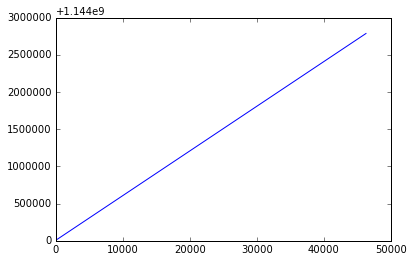

In [17]:
plt.plot(ts)

In [18]:
print "\ncreating dataframe",
sys.stdout.flush()
lk = len(dtime.keys())
xx=0
for i in dtime.keys():
    if xx%(int(lk/20))==0: print str(int(xx*100./lk))+"%",
    xx+=1
    dtime[i] = pd.DataFrame(dtime[i], columns=dsats[dsats.keys()[0]].columns)


creating dataframe 0% 4% 9% 14% 19% 24% 29% 34% 39% 44% 49% 54% 59% 64% 69% 74% 79% 84% 89% 94% 99%


In [19]:
dtime[dtime.keys()[0]]

,PRN,P1,P2,L1,L2,elev,azim,ipp_lat,ipp_lon,iono_delay_P,iono_delay_L,vtec_P,vtec_L,gpstime,s_iono_delay_P,s_vtec_P
0,1,20440823.516,20440828.352,1.074174e+08,8.370185e+07,68.245467,31.237925,-34.153197,-69.072838,7.475140,36657751.350903,6.942762,34046994.780863,1145307136,7.845960,7.295736
1,3,20703449.852,20703453.926,1.087979e+08,8.477752e+07,63.802059,186.220435,-36.622266,-70.009979,6.297295,37128915.321514,5.650401,33314819.213843,1145307136,6.705367,6.013777
2,9,22868231.141,22868236.680,1.201734e+08,9.364187e+07,28.621721,307.652719,-31.980063,-74.526754,8.561786,41010531.517912,4.101307,19645056.317423,1145307136,9.041889,4.305197
3,11,21791150.148,21791152.523,1.145135e+08,8.923118e+07,45.673755,4.085411,-32.327127,-69.574461,3.671103,39079517.087560,2.626207,27956421.283765,1145307136,3.010150,2.172465
4,17,22783413.461,22783415.191,1.197277e+08,9.329429e+07,29.662838,256.087204,-36.204943,-75.668481,2.674109,40858854.755077,1.323404,20220849.612469,1145307136,4.322782,2.139194
5,19,24461772.148,24461774.641,1.285475e+08,1.001669e+08,14.890468,226.060174,-40.969729,-78.123496,3.853499,43868696.794929,0.990242,11273027.570507,1145307136,3.843298,0.960487
6,22,20848711.930,20848711.961,1.095609e+08,8.537232e+07,54.950960,121.409257,-36.229593,-67.633453,0.047918,37389023.738181,0.039228,30608928.784966,1145307136,0.211456,0.171939
7,23,20558610.766,20558610.855,1.080364e+08,8.418436e+07,61.293691,302.540259,-34.286089,-71.463160,0.137570,36868761.735590,0.120662,32337343.135289,1145307136,0.763590,0.670525
8,31,23079764.625,23079764.891,1.212849e+08,9.450796e+07,26.154504,122.297646,-37.990777,-63.890884,0.411164,41389885.127447,0.181238,18244381.921479,1145307136,2.665762,1.172452


## 4. VTEC data summary at each time point

- **vmax** is the max VTEC at each time point w.r.t. the satellites in view at that moment.
- note that there are always between 4 and 12 satellites in view.
- likewise with the other data (vmean, vmin, vstd)

In [20]:
tvtec = []
for i in dtime.keys():
    rsat = dtime[i]
    gt = rsat.s_vtec_P.as_matrix()
    maxidx = np.argmax(gt)
    maxrecord = rsat.iloc[maxidx]
    maxprn = int(maxrecord["PRN"])
    maxipp_lat = maxrecord["ipp_lat"]
    maxipp_lon = maxrecord["ipp_lon"]
    tvtec += [[maxprn, maxipp_lat, maxipp_lon, np.mean(gt), np.std(gt), np.max(gt), np.min(gt), len(gt), int(i)]]
    
tvtec = pd.DataFrame(tvtec, columns=["PRN_vmax", "ipplat_vmax", "ipplon_vmax", "vmean", "vstd", "vmax", "vmin", "nsats", "gpstime"])
tvtec = add_gpsday(tvtec)
tvtec = add_second_in_orbit(tvtec, orbit_period=60*60*24-240)
tvtec = add_second_in_day(tvtec)


In [21]:
tvtec.head(10)

,PRN_vmax,ipplat_vmax,ipplon_vmax,vmean,vstd,vmax,vmin,nsats,gpstime,gpsday,secinorbit,b_secinorbit,secinday,b_secinday
0,1,-34.153197,-69.072838,2.766864,2.382816,7.295736,0.171939,9,1145307136,13255,68416,68400,75136,75120
1,24,-36.615801,-70.877064,2.076852,1.309733,5.180818,1.010551,7,1146290176,13267,17536,17520,21376,21360
2,1,-35.720710,-69.863478,2.907614,2.328061,7.521173,0.948611,9,1145044996,13252,64756,64740,72196,72180
3,1,-36.939523,-71.431900,3.401869,2.188075,6.661959,0.247242,10,1144782856,13249,61096,61080,69256,69240
4,24,-37.235497,-72.673532,1.894402,1.194416,4.770077,0.793008,8,1144564396,13247,14956,14940,23596,23580
5,8,-34.679323,-70.699994,4.475334,2.119042,7.882543,0.989104,9,1144520716,13246,57436,57420,66316,66300
6,27,-34.856115,-69.722829,4.949317,2.545448,8.584434,1.271219,11,1144258576,13243,53776,53760,63376,63360
7,30,-34.331160,-71.088726,2.709983,1.852326,5.478307,0.357454,6,1144804696,13250,82936,82920,4696,4680
8,25,-34.762169,-67.806346,1.640868,1.338166,5.058769,0.793939,8,1145962516,13263,34516,34500,39316,39300
9,25,-36.138086,-69.102495,1.277231,1.359301,4.929088,0.225837,9,1145700376,13260,30856,30840,36376,36360


In [22]:
print "check no missed data", len(tvtec), len(dtime.keys())

check no missed data 46321 46321


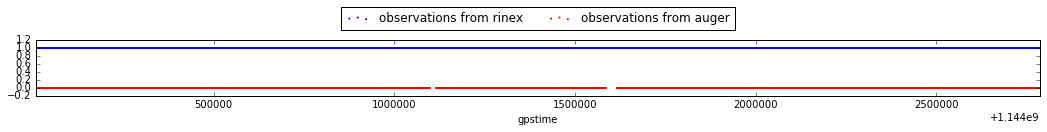

In [23]:
plt.figure(figsize=(18,1))
plt.scatter(tvtec.gpstime, np.ones(len(tvtec)), color="blue", s=1, label="observations from rinex")
plt.scatter( c.gpstime, np.zeros(len(c)), color="red", s=1, label="observations from auger")
plt.xlabel("gpstime")
plt.xlim([np.min(c.gpstime), np.max(c.gpstime)])
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.7),ncol=5)

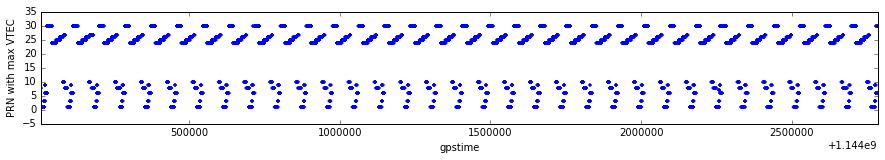

In [24]:
plt.figure(figsize=(15,2))
plt.scatter(tvtec.gpstime, tvtec.PRN_vmax, color="blue", s=3, alpha=0.5)
plt.xlim([np.min(tvtec.gpstime), np.max(tvtec.gpstime)])
plt.xlabel("gpstime")
plt.ylabel("PRN with max VTEC")

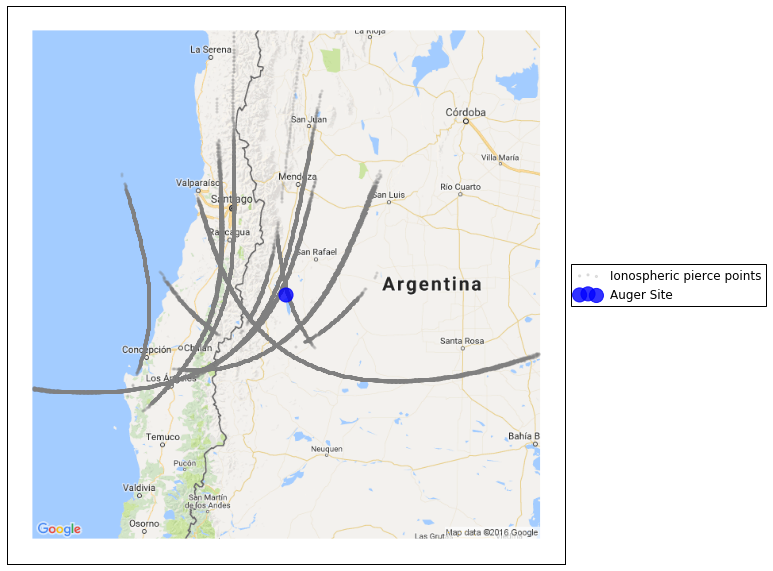

In [25]:
plt.figure(figsize=(10,10))

centerLat = -35.19
centerLon = -69.17

lats = tvtec.ipplat_vmax.as_matrix()
lons = tvtec.ipplon_vmax.as_matrix()
plot_inmap(centerLat, centerLon, lats, lons, zoom=6)

## 7. Can we predict VTEC max computed at ELA2 using ONLY GPS positions at Rouge? 

### prepare data for building models

find closest rinex observation for each monitoring observation

In [26]:
dtimes = tvtec.gpstime.astype(int)
cc = c[c.gpstime>=np.min(dtimes)]

mon_with_close_GPS_observation = np.array([np.min(np.abs(float(i)-dtimes))<120 for i in c.gpstime])
cc = c[mon_with_close_GPS_observation]

cc["rinextime"] = [dtimes[np.argmin((float(i)-dtimes)**2)] for i in cc.gpstime]
cc["secinday"]  = [i[1].gpstime%(86400) for i in cc.iterrows() ]

reindex VTEC data by time to merge it with monitoring data

In [27]:
kvtec = {}
for i in tvtec.iterrows():
    kvtec[int(i[1].gpstime)] = i[1][["vmean", "vstd", "vmax", "vmin", "nsats", "ipplat_vmax", "ipplon_vmax", "PRN_vmax"]]

merge VTEC data with monitoring data

In [28]:
for col in ["vmean", "vstd", "vmax", "vmin", "nsats", "ipplat_vmax", "ipplon_vmax", "PRN_vmax"]:
    cc[col] = [kvtec[i[1].rinextime][col] for i in cc.iterrows()]

In [29]:
print len(cc)
cc.head()

45473


,stationid,northing,easting,height,gpstime,secinorbit,b_secinorbit,gpsday,secinday,b_secinday,...,s_northing,rinextime,vmean,vstd,vmax,vmin,nsats,ipplat_vmax,ipplon_vmax,PRN_vmax
9,185,609054667,47087894,139514,1144007238,60918,60900,13240,71238,71220,...,609054667,1144007356,3.977257,2.058895,6.995281,1.310263,9,-32.664426,-70.600519,8
10,185,609054680,47087861,139548,1144007300,60980,60960,13240,71300,71280,...,609054680,1144007356,3.977257,2.058895,6.995281,1.310263,9,-32.664426,-70.600519,8
11,185,609054655,47087851,139415,1144007360,61040,61020,13240,71360,71340,...,609054655,1144007356,3.977257,2.058895,6.995281,1.310263,9,-32.664426,-70.600519,8
12,185,609054633,47087871,139423,1144007419,61099,61080,13240,71419,71400,...,609054633,1144007416,3.993333,2.081029,7.065479,1.288260,9,-32.620596,-70.601093,8
13,185,609054618,47087843,139332,1144007478,61158,61140,13240,71478,71460,...,609054618,1144007476,3.964907,2.068337,7.023731,1.217079,9,-32.576248,-70.601702,8


enhance data by adding the difference of each position with the previous one

In [30]:
cd = cc.copy().iloc[2:]
cd["ds_easting"] = cc.s_easting.iloc[1:-1].as_matrix() - cc.s_easting.iloc[:-2].as_matrix()
cd["ds_northing"] = cc.s_northing.iloc[1:-1].as_matrix() - cc.s_northing.iloc[:-2].as_matrix()
cd["ds_height"] = cc.s_height.iloc[1:-1].as_matrix() - cc.s_height.iloc[:-2].as_matrix()
cd["d_easting"] = cc.easting.iloc[1:-1].as_matrix() - cc.easting.iloc[:-2].as_matrix()
cd["d_northing"] = cc.northing.iloc[1:-1].as_matrix() - cc.northing.iloc[:-2].as_matrix()
cd["d_height"] = cc.height.iloc[1:-1].as_matrix() - cc.height.iloc[:-2].as_matrix()

cd["ds_total"] = np.sqrt(cd["ds_easting"]**2+cd["ds_northing"]**2+cd["ds_height"]**2)

ccd = cd.copy().iloc[2:]
ccd["dds_easting"] = cd.ds_easting.iloc[1:-1].as_matrix() - cd.ds_easting.iloc[:-2].as_matrix()
ccd["dds_northing"] = cd.ds_northing.iloc[1:-1].as_matrix() - cd.ds_northing.iloc[:-2].as_matrix()
ccd["dds_height"] = cd.ds_height.iloc[1:-1].as_matrix() - cd.ds_height.iloc[:-2].as_matrix()

cd = ccd

In [31]:
cd.iloc[0]

stationid       1.850000e+02
northing        6.090546e+08
easting         4.708784e+07
height          1.393320e+05
gpstime         1.144007e+09
secinorbit      6.115800e+04
b_secinorbit    6.114000e+04
gpsday          1.324000e+04
secinday        7.147800e+04
b_secinday      7.146000e+04
s_easting       4.708784e+07
s_height        1.393320e+05
s_northing      6.090546e+08
rinextime       1.144007e+09
vmean           3.964907e+00
vstd            2.068337e+00
vmax            7.023731e+00
vmin            1.217079e+00
nsats           9.000000e+00
ipplat_vmax    -3.257625e+01
ipplon_vmax    -7.060170e+01
PRN_vmax        8.000000e+00
ds_easting      2.000000e+01
ds_northing    -2.200000e+01
ds_height       8.000000e+00
d_easting       2.000000e+01
d_northing     -2.200000e+01
d_height        8.000000e+00
ds_total        3.078961e+01
dds_easting     2.300000e+01
dds_northing   -3.800000e+01
dds_height     -1.670000e+02
Name: 13, dtype: float64

In [33]:
import h5py
import deepdish as dd 
filename = "../rouge.ELA2"
cd.to_hdf(filename+"_dataset.hd5", "data")
tvtec.to_hdf(filename+"_vtecsummary.hd5", "data")
dd.io.save(filename+"_rinex_bysat.hd5", dsats)

zlib


## HOW MANY DAYS OF DATA WE NEED TO MAKE A MODEL??
For each day in the range [10, 32], we build a models with 1,2,3,..,10 previous days of data and measure their performances

In [203]:
input_columns = ["s_height", "s_northing", "s_easting", "ds_height", "ds_northing", "ds_easting"]
predict_column = "vmax"

days_for_training = [1,2,4,6,8,10,12]
test_results = {}
train_results = {}
for i in days_for_training:
    test_results[i] = []
    train_results[i] = []
    
for i in range(np.max(days_for_training), 32):
    print i,
    for d in days_for_training:
        train_days, test_days = range(i-d,i), [i]
        rf, ytrain_error, ytest_error, _,_ = build_NEH_model(cd, input_columns, predict_column, train_days,test_days, verbose=False)
        train_results[d].append(ytrain_error)
        test_results[d].append(ytest_error)

 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31


In [204]:
test_avgs = np.array([np.mean(test_results[i]) for i in np.sort(test_results.keys())])
test_stds = np.array([np.std(test_results[i]) for i in np.sort(test_results.keys())])
train_avgs = np.array([np.mean(train_results[i]) for i in np.sort(train_results.keys())])
train_stds = np.array([np.std(train_results[i]) for i in np.sort(train_results.keys())])


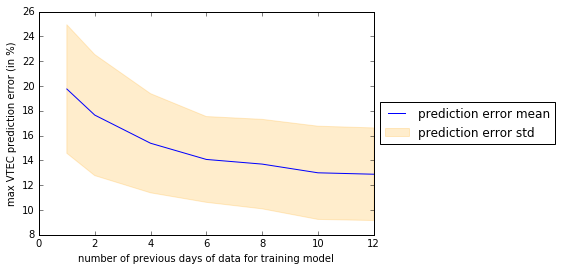

In [212]:
plt.plot(test_results.keys(), test_avgs, label="prediction error mean")
plt.fill_between(test_results.keys(), test_avgs-test_stds, test_avgs+test_stds, color="orange", alpha=0.2, label="prediction error std")
plt.xlabel("number of previous days of data for training model")
plt.ylabel("max VTEC prediction error (in %)")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));